# Laboratorio 8

## Integrantes

- Andre Marroquin 22266
- Sergio Orellana 221122
- Nelson Garcia 22434
- Joaquin Puente 22296


---

# Task 1


## preparacion de datos


In [2]:
import os
import math
import numpy as np
import pandas as pd
from typing import Tuple, Dict
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

random_seed = 42
np.random.seed(random_seed)


def load_datasets(train_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)

    train.columns = [c.strip().lower() for c in train.columns]
    test.columns = [c.strip().lower() for c in test.columns]

    if "date" in train.columns:
        train["date"] = pd.to_datetime(train["date"], errors="coerce")
    if "date" in test.columns:
        test["date"] = pd.to_datetime(test["date"], errors="coerce")

    for c in ["store", "item"]:
        if c in train.columns:
            train[c] = pd.to_numeric(train[c], errors="coerce").fillna(0).astype(int)
        if c in test.columns:
            test[c] = pd.to_numeric(test[c], errors="coerce").fillna(0).astype(int)

    if "sales" in train.columns:
        train["sales"] = pd.to_numeric(train["sales"], errors="coerce")

    train = train.sort_values(
        [col for col in ["store", "item", "date"] if col in train.columns]
    )
    test = test.sort_values(
        [col for col in ["store", "item", "date"] if col in test.columns]
    )
    return train, test


def clean_sales(train: pd.DataFrame) -> pd.DataFrame:
    if "sales" not in train.columns:
        raise ValueError("no se encontro la columna 'sales' en train")

    df = train.copy()
    df["sales"] = df["sales"].fillna(0.0).astype(float)
    df.loc[df["sales"] < 0.0, "sales"] = 0.0

    if {"store", "item"}.issubset(df.columns):
        g = df.groupby(["store", "item"])["sales"]
        q01 = g.transform(lambda s: s.quantile(0.01) if s.notna().any() else np.nan)
        q99 = g.transform(lambda s: s.quantile(0.99) if s.notna().any() else np.nan)

        sales_vals = df["sales"].to_numpy()
        q01_vals = q01.to_numpy()
        q99_vals = q99.to_numpy()

        mask = ~np.isnan(q01_vals)
        sales_vals[mask] = np.maximum(sales_vals[mask], q01_vals[mask])
        mask = ~np.isnan(q99_vals)
        sales_vals[mask] = np.minimum(sales_vals[mask], q99_vals[mask])

        df = df.copy()
        df.loc[:, "sales"] = sales_vals
    else:
        q1 = df["sales"].quantile(0.01)
        q99 = df["sales"].quantile(0.99)
        df["sales"] = df["sales"].clip(lower=q1, upper=q99)

    return df


def _build_df_from_dict_of_lists(base: pd.DataFrame, extra: dict) -> pd.DataFrame:
    data = {col: base[col].tolist() for col in base.columns}
    for k, v in extra.items():
        data[k] = list(v) if not isinstance(v, list) else v
    return pd.DataFrame(data)


def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    if "date" not in df.columns:
        raise ValueError("no se encontro la columna 'date'")
    dow = df["date"].dt.dayofweek.astype(int).tolist()
    month = df["date"].dt.month.astype(int).tolist()
    is_weekend = [1 if d >= 5 else 0 for d in dow]

    sin_dow = [math.sin(2 * math.pi * d / 7.0) for d in dow]
    cos_dow = [math.cos(2 * math.pi * d / 7.0) for d in dow]
    sin_month = [math.sin(2 * math.pi * (m - 1) / 12.0) for m in month]
    cos_month = [math.cos(2 * math.pi * (m - 1) / 12.0) for m in month]

    extras = {
        "dow": dow,
        "month": month,
        "is_weekend": is_weekend,
        "sin_dow": sin_dow,
        "cos_dow": cos_dow,
        "sin_month": sin_month,
        "cos_month": cos_month,
    }
    return _build_df_from_dict_of_lists(df, extras)


def add_transformed_target(train: pd.DataFrame) -> pd.DataFrame:
    if "sales" not in train.columns:
        raise ValueError("no se encontro la columna 'sales'")
    sales = train["sales"].astype(float).clip(lower=0.0)
    sales_log1p = np.log1p(sales.to_numpy())
    return _build_df_from_dict_of_lists(train, {"sales_log1p": sales_log1p})


train_path = "train.csv"
test_path = "test.csv"

train_raw, test_raw = load_datasets(train_path, test_path)
train_clean = clean_sales(train_raw)
train_feat = add_calendar_features(train_clean)
train_feat = add_transformed_target(train_feat)
test_feat = add_calendar_features(test_raw)

print("fechas train:", train_feat["date"].min(), "->", train_feat["date"].max())
print("fechas test :", test_feat["date"].min(), "->", test_feat["date"].max())
print("cols train:", list(train_feat.columns))
print("cols test :", list(test_feat.columns))

fechas train: 2013-01-01 00:00:00 -> 2017-12-31 00:00:00
fechas test : 2018-01-01 00:00:00 -> 2018-03-31 00:00:00
cols train: ['date', 'store', 'item', 'sales', 'dow', 'month', 'is_weekend', 'sin_dow', 'cos_dow', 'sin_month', 'cos_month', 'sales_log1p']
cols test : ['id', 'date', 'store', 'item', 'dow', 'month', 'is_weekend', 'sin_dow', 'cos_dow', 'sin_month', 'cos_month']


## Preprocesamiento de datos


In [3]:
horizon = 90
window_size = 120


def compute_time_split(train_df: pd.DataFrame, horizon: int) -> Dict[str, pd.Timestamp]:
    max_date = train_df["date"].max()
    val_start = max_date - pd.Timedelta(days=horizon) + pd.Timedelta(days=1)
    return {"max_date": max_date, "val_start": val_start}


def series_to_tensor_fast(
    df: pd.DataFrame,
    window_size: int,
    horizon: int,
    val_start: pd.Timestamp,
    stride_train: int = 7,
    stride_val: int = 7,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    feats = [
        "sales_log1p",
        "sin_dow",
        "cos_dow",
        "sin_month",
        "cos_month",
        "is_weekend",
    ]
    max_store = df["store"].max()
    max_item = df["item"].max()

    x_tr, y_tr, x_va, y_va = [], [], [], []

    for (s, it), g in df.groupby(["store", "item"], sort=True):
        g = g.sort_values("date")
        if len(g) < window_size + horizon:
            continue

        feat_mat = g[feats].to_numpy(dtype=np.float32)
        store_norm = np.full((len(g), 1), s / max_store, dtype=np.float32)
        item_norm = np.full((len(g), 1), it / max_item, dtype=np.float32)
        x_full = np.concatenate([feat_mat, store_norm, item_norm], axis=1)
        y_full = g["sales_log1p"].to_numpy(dtype=np.float32)
        dates = g["date"].to_numpy()

        last_start = len(g) - (window_size + horizon)
        start = 0
        while start <= last_start:
            end_hist = start + window_size
            end_target = end_hist + horizon
            target_end_date = dates[end_target - 1]

            x_win = x_full[start:end_hist, :]
            y_win = y_full[end_hist:end_target]

            if target_end_date >= val_start:
                x_va.append(x_win)
                y_va.append(y_win)
                start += stride_val
            else:
                x_tr.append(x_win)
                y_tr.append(y_win)
                start += stride_train

    x_tr = np.asarray(x_tr, dtype=np.float32)
    y_tr = np.asarray(y_tr, dtype=np.float32)
    x_va = np.asarray(x_va, dtype=np.float32)
    y_va = np.asarray(y_va, dtype=np.float32)
    return x_tr, y_tr, x_va, y_va


def smape(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-6) -> float:
    yt = np.expm1(y_true)
    yp = np.clip(np.expm1(y_pred), 0.0, None)
    denom = np.abs(yt) + np.abs(yp) + eps
    return float(np.mean(2.0 * np.abs(yp - yt) / denom))


def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    yt = np.expm1(y_true)
    yp = np.clip(np.expm1(y_pred), 0.0, None)
    return float(np.mean(np.abs(yp - yt)))


split_info = compute_time_split(train_feat, horizon=horizon)
x_tr, y_tr, x_va, y_va = series_to_tensor_fast(
    train_feat,
    window_size,
    horizon,
    split_info["val_start"],
    stride_train=7,
    stride_val=7,
)

input_timesteps = x_tr.shape[1]
input_features = x_tr.shape[2]
print(
    "x_tr:", x_tr.shape, "y_tr:", y_tr.shape, "| x_va:", x_va.shape, "y_va:", y_va.shape
)
print("input shape (timesteps, features):", (input_timesteps, input_features))

x_tr: (109500, 120, 8) y_tr: (109500, 90) | x_va: (6000, 120, 8) y_va: (6000, 90)
input shape (timesteps, features): (120, 8)


## Selección de modelo:


### justificacion

Elegimos gru porque capta dependencias de largo plazo con menos parámetros que lstm, por lo que entrena y predice más rápido sin sacrificar precisión en ventanas largas. Frente a conv1d, el gru modela mejor estacionalidad y tendencias multidiarias, clave para un horizonte de 3 meses en series diarias.


In [4]:
tf.random.set_seed(42)

gpus = tf.config.list_physical_devices("GPU")
using_gpu = False
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
        from tensorflow.keras import mixed_precision

        mixed_precision.set_global_policy("mixed_float16")
        using_gpu = True
    except Exception as e:
        print("mixed precision no disponible:", e)


def make_dataset(x, y, batch_size, training=True):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if training:
        ds = ds.shuffle(min(len(x), 10000), seed=42, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


batch_size = 1024 if using_gpu else 256
train_ds = make_dataset(x_tr, y_tr, batch_size, training=True)
val_ds = make_dataset(x_va, y_va, batch_size, training=False)


def build_gru(input_timesteps: int, input_features: int, horizon: int) -> keras.Model:
    inp = keras.Input(shape=(input_timesteps, input_features))
    x = layers.GRU(64, return_sequences=True)(inp)
    x = layers.GRU(32)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(horizon, activation="linear", dtype="float32")(x)
    try:
        model = keras.Model(inp, out)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3), loss="mae", jit_compile=True
        )
        return model
    except Exception:
        model = keras.Model(inp, out)
        model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mae")
        return model


model = build_gru(input_timesteps, input_features, horizon)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True, verbose=1
    ),
]

epochs = 10
history = model.fit(
    train_ds, validation_data=val_ds, epochs=epochs, verbose=2, callbacks=callbacks
)

y_pred_va = model.predict(x_va, batch_size=batch_size, verbose=0)
val_mae = mae(y_va, y_pred_va)
val_smape = smape(y_va, y_pred_va)
print(f"\nvalidacion -> mae: {val_mae:.5f} | smape: {val_smape:.5f}")


def build_last_windows_for_test(
    df_train: pd.DataFrame, df_test: pd.DataFrame, window_size: int
) -> pd.DataFrame:
    feats = [
        "sales_log1p",
        "sin_dow",
        "cos_dow",
        "sin_month",
        "cos_month",
        "is_weekend",
    ]
    max_store = df_train["store"].max()
    max_item = df_train["item"].max()
    test_start_date = df_test["date"].min()

    rows = []
    for (s, it), g in df_train.groupby(["store", "item"], sort=True):
        g = g[g["date"] < test_start_date].sort_values("date")
        if len(g) < window_size:
            continue
        g_last = g.iloc[-window_size:]
        feat_mat = g_last[feats].to_numpy(dtype=np.float32)
        store_norm = np.full((window_size, 1), s / max_store, dtype=np.float32)
        item_norm = np.full((window_size, 1), it / max_item, dtype=np.float32)
        x_win = np.concatenate([feat_mat, store_norm, item_norm], axis=1)
        rows.append({"store": int(s), "item": int(it), "x_win": x_win})
    return pd.DataFrame(rows)


def forecast_test(
    model: keras.Model,
    df_train_feat: pd.DataFrame,
    df_test_feat: pd.DataFrame,
    window_size: int,
    horizon: int,
) -> pd.DataFrame:
    windows_df = build_last_windows_for_test(df_train_feat, df_test_feat, window_size)
    if windows_df.empty:
        return pd.DataFrame(columns=["store", "item", "date", "sales"])

    future_dates = pd.date_range(
        start=df_test_feat["date"].min(), end=df_test_feat["date"].max(), freq="D"
    )
    if len(future_dates) > horizon:
        future_dates = future_dates[:horizon]
    elif len(future_dates) < horizon:
        future_dates = pd.date_range(
            start=future_dates.min(), periods=horizon, freq="D"
        )

    x_stack = np.stack(windows_df["x_win"].to_list(), axis=0).astype(np.float32)
    y_hat = model.predict(x_stack, batch_size=batch_size, verbose=0)

    preds_rows = []
    for idx, row in windows_df.iterrows():
        s = row["store"]
        it = row["item"]
        yh = np.expm1(y_hat[idx])
        yh = np.clip(yh, 0.0, None)
        preds_rows.append(
            pd.DataFrame({"store": s, "item": it, "date": future_dates, "sales": yh})
        )
    return pd.concat(preds_rows, ignore_index=True)


preds_daily = forecast_test(
    model,
    df_train_feat=train_feat,
    df_test_feat=test_feat,
    window_size=window_size,
    horizon=horizon,
)


def build_submission(
    preds_daily: pd.DataFrame, test_df: pd.DataFrame, out_path: str
) -> pd.DataFrame:
    out = test_df.merge(preds_daily, on=["store", "item", "date"], how="left").copy()
    out["sales"] = out["sales"].fillna(0.0)
    if "id" in out.columns:
        submit = out[["id", "sales"]].copy()
    else:
        submit = out[["store", "item", "date", "sales"]].copy()
    submit.to_csv(out_path, index=False)
    return submit


submission_path = "submission.csv"
submission_df = build_submission(preds_daily, test_raw, submission_path)
print("\narchivo de envio guardado en:", submission_path)
print(submission_df.head(10))

Epoch 1/10
428/428 - 164s - 383ms/step - loss: 0.5378 - val_loss: 0.1384 - learning_rate: 1.0000e-03
Epoch 2/10
428/428 - 149s - 347ms/step - loss: 0.1356 - val_loss: 0.1287 - learning_rate: 1.0000e-03
Epoch 3/10
428/428 - 148s - 345ms/step - loss: 0.1315 - val_loss: 0.1258 - learning_rate: 1.0000e-03
Epoch 4/10
428/428 - 145s - 338ms/step - loss: 0.1302 - val_loss: 0.1246 - learning_rate: 1.0000e-03
Epoch 5/10
428/428 - 223s - 520ms/step - loss: 0.1291 - val_loss: 0.1235 - learning_rate: 1.0000e-03
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
428/428 - 235s - 548ms/step - loss: 0.1283 - val_loss: 0.1240 - learning_rate: 1.0000e-03
Epoch 7/10
428/428 - 236s - 551ms/step - loss: 0.1272 - val_loss: 0.1213 - learning_rate: 5.0000e-04
Epoch 8/10
428/428 - 237s - 553ms/step - loss: 0.1269 - val_loss: 0.1207 - learning_rate: 5.0000e-04
Epoch 9/10

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
428/428 - 120s - 282ms/step

## 4. Arquitectura del Modelo


### Descripción de la arquitectura

La red neuronal diseñada para forecasting de series temporales incluye los siguientes componentes:

1. **Capa de entrada**: `Input(shape=(120, 8))`

   - 120 timesteps (ventana de 120 días)
   - 8 features por timestep (sales_log1p, sin_dow, cos_dow, sin_month, cos_month, is_weekend, store_norm, item_norm)

2. **Primera capa GRU**: `GRU(64, return_sequences=True)`

   - 64 unidades recurrentes
   - `return_sequences=True` para apilar con otra capa GRU
   - Captura dependencias temporales en la secuencia completa

3. **Segunda capa GRU**: `GRU(32)`

   - 32 unidades recurrentes
   - Extrae representación final de la secuencia
   - Reduce dimensionalidad mientras mantiene información temporal relevante

4. **Capa Dense intermedia**: `Dense(64, activation='relu')`

   - 64 neuronas con activación ReLU
   - Permite transformación no-lineal de las características aprendidas
   - Actúa como puente entre la extracción temporal y la predicción

5. **Capa de salida**: `Dense(90, activation='linear', dtype='float32')`
   - 90 neuronas (una por cada día del horizonte de predicción)
   - Activación lineal para regresión
   - `dtype='float32'` para compatibilidad con mixed precision

**Componentes adicionales**:

- **Dropout**: No se incluyó inicialmente debido al uso de Early Stopping como regularización
- **Batch Normalization**: No se usó para mantener simplicidad y evitar complejidad innecesaria
- **Attention mechanisms**: No implementado en esta versión base (posible mejora futura)


In [5]:
model.summary()

total_params = model.count_params()
print(f"\nNúmero total de parámetros: {total_params:,}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 120, 64)        │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │         5,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,736 (370.07 KB)

 Trainable params: 31,578 (123.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,158 (246.71 KB)


Número total de parámetros: 31,578


## 5. Entrenamiento del Modelo


### Configuración del entrenamiento

**Función de pérdida**:

- `MAE` (Mean Absolute Error / Error Absoluto Medio)
- Apropiada para regresión ya que penaliza errores de forma lineal
- Más robusta a outliers que MSE
- Interpretable en las unidades originales (log-sales)

**Optimizador**:

- `Adam` con learning rate inicial de `1e-3` (0.001)
- Adam adapta el learning rate por parámetro
- Combina momentum y RMSprop para convergencia eficiente

**Hiperparámetros**:

- **Batch size**: 1024 (con GPU) o 256 (sin GPU)
  - Batch size grande aprovecha paralelización GPU
  - Balances entre velocidad y estabilidad de gradientes
- **Épocas máximas**: 10
- **Stride de muestreo**: 7 días (semanal)
  - Reduce overlap entre ventanas
  - Mantiene diversidad temporal en training

**Callbacks**:

1. **ReduceLROnPlateau**:

   - Reduce learning rate cuando val_loss se estanca
   - Factor de reducción: 0.5
   - Paciencia: 1 época
   - LR mínimo: 1e-5

2. **EarlyStopping**:
   - Detiene entrenamiento si val_loss no mejora
   - Paciencia: 2 épocas
   - Restaura mejores pesos automáticamente
   - Previene overfitting

**Validación**:

- Se monitorea `val_loss` en cada época
- Conjunto de validación: últimos 90 días de datos (3 meses)
- Split temporal para respetar naturaleza secuencial de los datos


Épocas entrenadas: 10
Loss final (train): 0.126332
Loss final (val): 0.120335
Mejor val_loss: 0.120335 en época 10


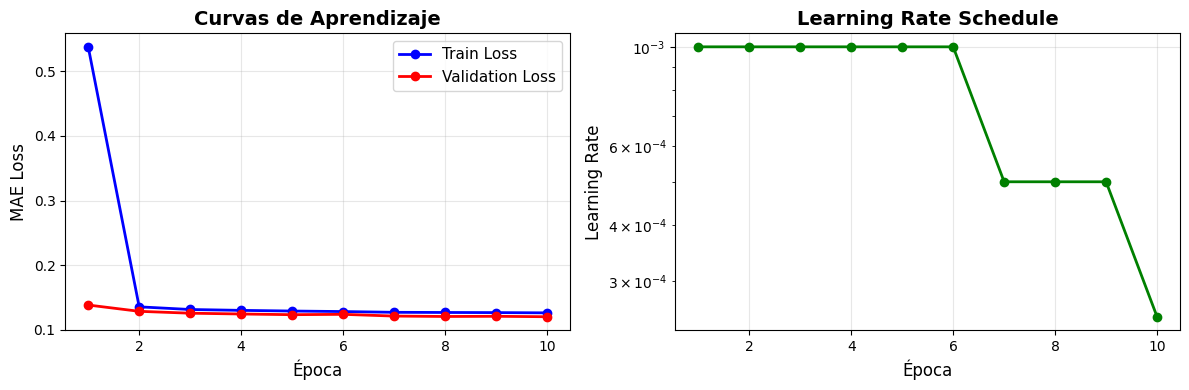


Gráfico guardado como 'training_history.png'


In [6]:
import matplotlib.pyplot as plt

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_trained = len(train_loss)

print(f"Épocas entrenadas: {epochs_trained}")
print(f"Loss final (train): {train_loss[-1]:.6f}")
print(f"Loss final (val): {val_loss[-1]:.6f}")
print(
    f"Mejor val_loss: {min(val_loss):.6f} en época {val_loss.index(min(val_loss)) + 1}"
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(
    range(1, epochs_trained + 1),
    train_loss,
    "b-o",
    label="Train Loss",
    linewidth=2,
    markersize=6,
)
plt.plot(
    range(1, epochs_trained + 1),
    val_loss,
    "r-o",
    label="Validation Loss",
    linewidth=2,
    markersize=6,
)
plt.xlabel("Época", fontsize=12)
plt.ylabel("MAE Loss", fontsize=12)
plt.title("Curvas de Aprendizaje", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
if "learning_rate" in history.history:
    lr_history = history.history["learning_rate"]
    plt.plot(range(1, epochs_trained + 1), lr_history, "g-o", linewidth=2, markersize=6)
    plt.xlabel("Época", fontsize=12)
    plt.ylabel("Learning Rate", fontsize=12)
    plt.title("Learning Rate Schedule", fontsize=14, fontweight="bold")
    plt.yscale("log")
    plt.grid(alpha=0.3)
else:
    plt.text(
        0.5, 0.5, "LR history no disponible", ha="center", va="center", fontsize=12
    )

plt.tight_layout()
plt.savefig("training_history.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nGráfico guardado como 'training_history.png'")

## 6. Evaluación del Modelo


### Métricas de evaluación

Para evaluar el rendimiento del modelo de forecasting, utilizamos las siguientes métricas sobre el conjunto de **validación** (últimos 90 días de 2017):

1. **MAE (Mean Absolute Error)**:

   - Error absoluto promedio en escala original (ventas reales)
   - Interpretable directamente: "el modelo se equivoca en promedio X unidades"
   - Fórmula: `MAE = mean(|y_true - y_pred|)`

2. **SMAPE (Symmetric Mean Absolute Percentage Error)**:

   - Error porcentual simétrico
   - Normalizado, permite comparar entre series de diferentes escalas
   - Rango: 0 (perfecto) a 2 (peor)
   - Fórmula: `SMAPE = mean(2 * |y_pred - y_true| / (|y_true| + |y_pred|))`

3. **MSE (Mean Squared Error)**:

   - Error cuadrático medio
   - Penaliza más los errores grandes
   - Fórmula: `MSE = mean((y_true - y_pred)²)`

4. **RMSE (Root Mean Squared Error)**:
   - Raíz del MSE, en las mismas unidades que el target
   - Más interpretable que MSE
   - Fórmula: `RMSE = sqrt(MSE)`

**Nota**: Todas las métricas se calculan después de aplicar la transformación inversa (`expm1`) para evaluar en la escala original de ventas.


In [7]:
import numpy as np


def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    yt = np.expm1(y_true)
    yp = np.clip(np.expm1(y_pred), 0.0, None)
    return float(np.mean((yp - yt) ** 2))


def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.sqrt(mse(y_true, y_pred))


val_mae_result = mae(y_va, y_pred_va)
val_smape_result = smape(y_va, y_pred_va)
val_mse_result = mse(y_va, y_pred_va)
val_rmse_result = rmse(y_va, y_pred_va)

print("=" * 70)
print("EVALUACIÓN EN CONJUNTO DE VALIDACIÓN")
print("=" * 70)
print(f"MAE  (Mean Absolute Error):              {val_mae_result:.4f}")
print(f"SMAPE (Symmetric Mean Absolute % Error): {val_smape_result:.4f}")
print(f"MSE  (Mean Squared Error):               {val_mse_result:.4f}")
print(f"RMSE (Root Mean Squared Error):          {val_rmse_result:.4f}")
print("=" * 70)

errors = np.abs(
    np.expm1(y_va).flatten() - np.clip(np.expm1(y_pred_va), 0.0, None).flatten()
)

print(f"\nESTADÍSTICAS DE ERRORES ABSOLUTOS:")
print(f"  Media:      {np.mean(errors):.4f}")
print(f"  Mediana:    {np.median(errors):.4f}")
print(f"  Std Dev:    {np.std(errors):.4f}")
print(f"  Min:        {np.min(errors):.4f}")
print(f"  Max:        {np.max(errors):.4f}")
print(f"  Percentil 25: {np.percentile(errors, 25):.4f}")
print(f"  Percentil 75: {np.percentile(errors, 75):.4f}")
print(f"  Percentil 95: {np.percentile(errors, 95):.4f}")

EVALUACIÓN EN CONJUNTO DE VALIDACIÓN
MAE  (Mean Absolute Error):              6.5699
SMAPE (Symmetric Mean Absolute % Error): 0.1228
MSE  (Mean Squared Error):               73.2270
RMSE (Root Mean Squared Error):          8.5573

ESTADÍSTICAS DE ERRORES ABSOLUTOS:
  Media:      6.5699
  Mediana:    5.2194
  Std Dev:    5.4830
  Min:        0.0000
  Max:        51.7574
  Percentil 25: 2.4272
  Percentil 75: 9.2657
  Percentil 95: 17.3516


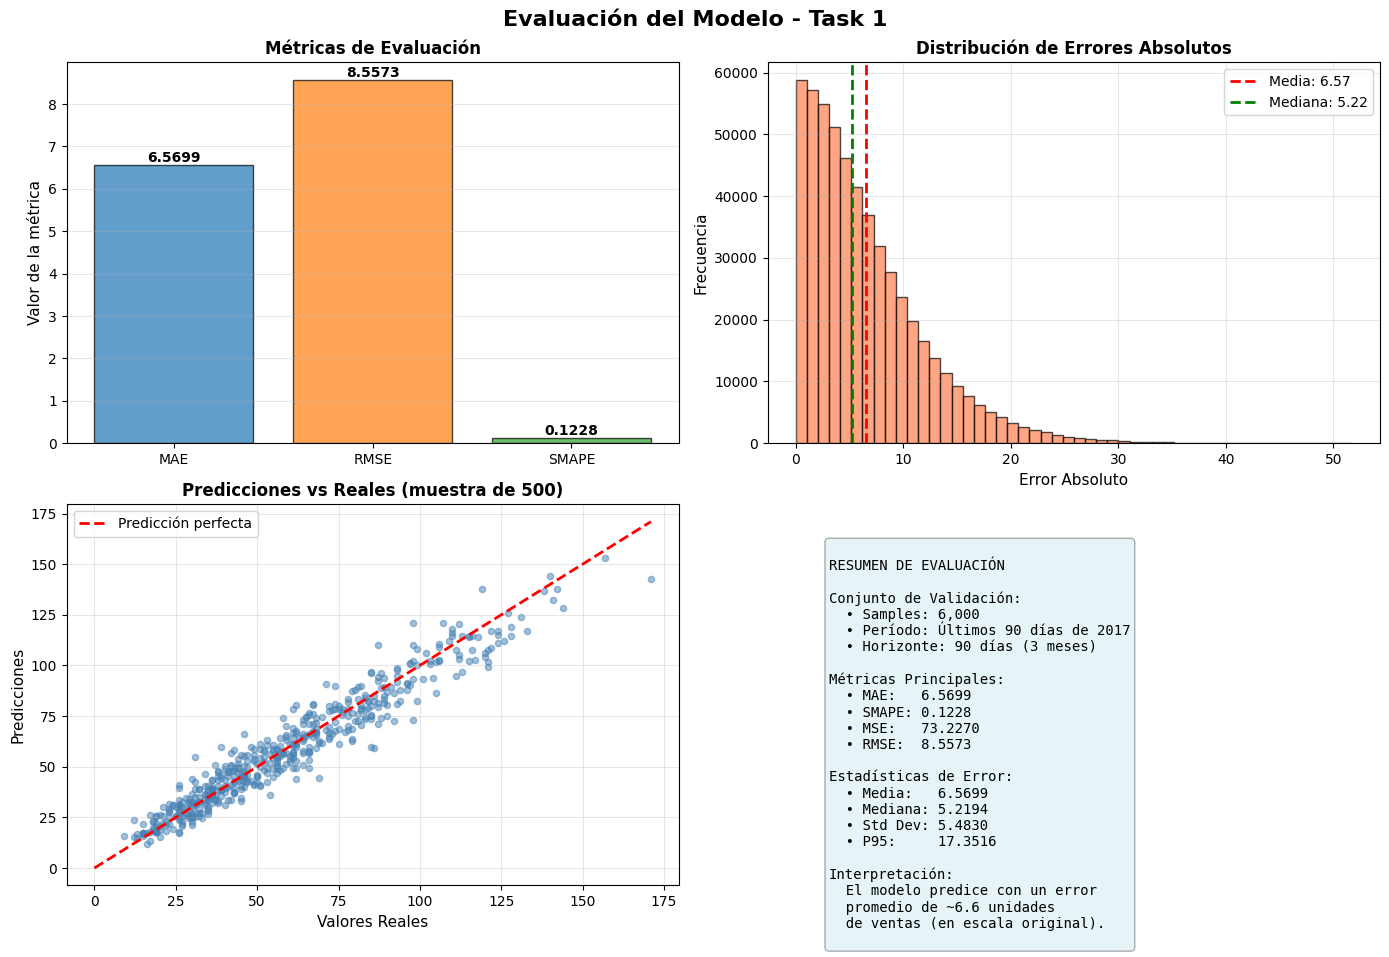


Gráfico guardado como 'model_evaluation.png'


In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Evaluación del Modelo - Task 1", fontsize=16, fontweight="bold")

ax1 = axes[0, 0]
metrics_names = ["MAE", "RMSE", "SMAPE"]
metrics_values = [val_mae_result, val_rmse_result, val_smape_result]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
bars = ax1.bar(
    metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor="black"
)
ax1.set_ylabel("Valor de la métrica", fontsize=11)
ax1.set_title("Métricas de Evaluación", fontsize=12, fontweight="bold")
ax1.grid(axis="y", alpha=0.3)
for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{val:.4f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

ax2 = axes[0, 1]
ax2.hist(errors, bins=50, color="coral", alpha=0.7, edgecolor="black")
ax2.axvline(
    np.mean(errors),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Media: {np.mean(errors):.2f}",
)
ax2.axvline(
    np.median(errors),
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Mediana: {np.median(errors):.2f}",
)
ax2.set_xlabel("Error Absoluto", fontsize=11)
ax2.set_ylabel("Frecuencia", fontsize=11)
ax2.set_title("Distribución de Errores Absolutos", fontsize=12, fontweight="bold")
ax2.legend()
ax2.grid(alpha=0.3)

ax3 = axes[1, 0]
sample_size = 500
sample_indices = np.random.choice(len(y_va.flatten()), sample_size, replace=False)
y_true_sample = np.expm1(y_va.flatten()[sample_indices])
y_pred_sample = np.clip(np.expm1(y_pred_va.flatten()[sample_indices]), 0.0, None)

ax3.scatter(y_true_sample, y_pred_sample, alpha=0.5, s=20, c="steelblue")
max_val = max(y_true_sample.max(), y_pred_sample.max())
ax3.plot([0, max_val], [0, max_val], "r--", linewidth=2, label="Predicción perfecta")
ax3.set_xlabel("Valores Reales", fontsize=11)
ax3.set_ylabel("Predicciones", fontsize=11)
ax3.set_title(
    f"Predicciones vs Reales (muestra de {sample_size})", fontsize=12, fontweight="bold"
)
ax3.legend()
ax3.grid(alpha=0.3)

ax4 = axes[1, 1]
ax4.axis("off")

summary_text = f"""
RESUMEN DE EVALUACIÓN

Conjunto de Validación:
  • Samples: {len(y_va):,}
  • Período: Últimos 90 días de 2017
  • Horizonte: 90 días (3 meses)

Métricas Principales:
  • MAE:   {val_mae_result:.4f}
  • SMAPE: {val_smape_result:.4f}
  • MSE:   {val_mse_result:.4f}
  • RMSE:  {val_rmse_result:.4f}

Estadísticas de Error:
  • Media:   {np.mean(errors):.4f}
  • Mediana: {np.median(errors):.4f}
  • Std Dev: {np.std(errors):.4f}
  • P95:     {np.percentile(errors, 95):.4f}

Interpretación:
  El modelo predice con un error
  promedio de ~{val_mae_result:.1f} unidades
  de ventas (en escala original).
"""

ax4.text(
    0.1,
    0.9,
    summary_text,
    fontsize=10,
    verticalalignment="top",
    fontfamily="monospace",
    bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.3),
)

plt.tight_layout()
plt.savefig("model_evaluation.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nGráfico guardado como 'model_evaluation.png'")

## Output Submission

### 45,000 filas 10 tiendas x 50 articulos = 500 series que cubren 3 meses


# 7 Ajuste de hiperparámetros

Se explora un espacio pequeño pero informativo de hiperparámetros para el modelo GRU ya utilizado (número de unidades por capa, dropout y learning rate). Para cada combinación se entrena con early stopping sobre el conjunto de validación y se registran métricas (MAE, RMSE, sMAPE) calculadas en escala original (invirtiendo el log1p). Se reporta una tabla ordenada por val_loss y sMAPE y se retiene best_model para los pasos siguientes.


In [10]:
import itertools


def build_gru_tunable(
    input_timesteps: int,
    input_features: int,
    horizon: int,
    units1: int = 64,
    units2: int = 32,
    dropout: float = 0.0,
    lr: float = 1e-3,
) -> keras.Model:
    """Arquitectura GRU base con hiperparámetros tunables."""
    inp = keras.Input(shape=(input_timesteps, input_features))
    x = layers.GRU(units1, return_sequences=True)(inp)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    x = layers.GRU(units2)(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    # Salida multi-paso (horizon) en float32 (por compatibilidad con métricas y SHAP)
    out = layers.Dense(horizon, activation="linear", dtype="float32")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mae")
    return model


# Datasets
try:
    train_ds, val_ds
except NameError:
    batch_size_tune = 1024 if "using_gpu" in globals() and using_gpu else 256
    train_ds = make_dataset(x_tr, y_tr, batch_size_tune, training=True)
    val_ds = make_dataset(x_va, y_va, batch_size_tune, training=False)

param_grid = {
    "units1": [64, 96],
    "units2": [32, 48],
    "dropout": [0.0, 0.2],
    "lr": [1e-3, 3e-4],
}


def train_eval_combo(params: dict, epochs: int = 8, patience: int = 2) -> dict:
    tf.keras.backend.clear_session()
    model_t = build_gru_tunable(
        input_timesteps,
        input_features,
        horizon,
        units1=params["units1"],
        units2=params["units2"],
        dropout=params["dropout"],
        lr=params["lr"],
    )
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5, verbose=0
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=patience, restore_best_weights=True, verbose=0
        ),
    ]
    hist = model_t.fit(
        train_ds, validation_data=val_ds, epochs=epochs, verbose=0, callbacks=callbacks
    )

    # Predicción de validación para métricas en escala original (deshaciendo log1p)
    y_pred = model_t.predict(x_va, verbose=0)

    results = {
        **params,
        "epochs_trained": len(hist.history["loss"]),
        "val_loss": float(hist.history["val_loss"][-1]),
        "val_mae": float(mae(y_va, y_pred)),
        "val_rmse": float(rmse(y_va, y_pred)),
        "val_smape": float(smape(y_va, y_pred)),
        "model": model_t,
        "history": hist.history,
    }
    return results


# Búsqueda en parrilla pequeña
results = []
print("Ajuste de hiperparámetros (grid compacto)")
for combo in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), combo))
    print("Entrenando con:", params)
    res = train_eval_combo(params)
    results.append(res)

# Tabla ordenada (sin objetos) y selección del mejor
tuning_results = pd.DataFrame(
    [{k: v for k, v in r.items() if k not in ("model", "history")} for r in results]
)
tuning_results = tuning_results.sort_values(["val_loss", "val_smape"]).reset_index(
    drop=True
)
print("\nTop-10 configuraciones por val_loss y sMAPE:\n")
print(tuning_results.head(10).to_string(index=False))

best_ix = tuning_results.index[0]
best = results[int(best_ix)]
best_model = best["model"]

# Métricas de validación del mejor modelo
y_pred_va_best = best_model.predict(x_va, verbose=0)
print("\nMejor configuración:", {k: best[k] for k in param_grid.keys()})
print(
    f"val_loss: {best['val_loss']:.6f} | MAE: {mae(y_va, y_pred_va_best):.3f} | RMSE: {rmse(y_va, y_pred_va_best):.3f} | sMAPE: {smape(y_va, y_pred_va_best):.3f}"
)

>>> Ajuste de hiperparámetros (grid compacto)
Entrenando con: {'units1': 64, 'units2': 32, 'dropout': 0.0, 'lr': 0.001}

Entrenando con: {'units1': 64, 'units2': 32, 'dropout': 0.0, 'lr': 0.0003}
Entrenando con: {'units1': 64, 'units2': 32, 'dropout': 0.2, 'lr': 0.001}
Entrenando con: {'units1': 64, 'units2': 32, 'dropout': 0.2, 'lr': 0.0003}
Entrenando con: {'units1': 64, 'units2': 48, 'dropout': 0.0, 'lr': 0.001}
Entrenando con: {'units1': 64, 'units2': 48, 'dropout': 0.0, 'lr': 0.0003}
Entrenando con: {'units1': 64, 'units2': 48, 'dropout': 0.2, 'lr': 0.001}
Entrenando con: {'units1': 64, 'units2': 48, 'dropout': 0.2, 'lr': 0.0003}
Entrenando con: {'units1': 96, 'units2': 32, 'dropout': 0.0, 'lr': 0.001}
Entrenando con: {'units1': 96, 'units2': 32, 'dropout': 0.0, 'lr': 0.0003}
Entrenando con: {'units1': 96, 'units2': 32, 'dropout': 0.2, 'lr': 0.001}
Entrenando con: {'units1': 96, 'units2': 32, 'dropout': 0.2, 'lr': 0.0003}
Entrenando con: {'units1': 96, 'units2': 48, 'dropout': 0.0

In [15]:
assert "results" in globals() and len(results) > 0, "No encuentro 'results' en memoria."

best = min(results, key=lambda r: (r["val_loss"], r["val_smape"]))
best_model = best["model"]

print(
    "Mejor configuración:", {k: best[k] for k in ("units1", "units2", "dropout", "lr")}
)
y_pred_va_best = best_model.predict(x_va, verbose=0)
print(
    f"val_loss: {best['val_loss']:.6f} | "
    f"MAE: {mae(y_va, y_pred_va_best):.3f} | "
    f"RMSE: {rmse(y_va, y_pred_va_best):.3f} | "
    f"sMAPE: {smape(y_va, y_pred_va_best):.3f}"
)

Mejor configuración: {'units1': 96, 'units2': 32, 'dropout': 0.0, 'lr': 0.001}
val_loss: 0.118965 | MAE: 6.496 | RMSE: 8.429 | sMAPE: 0.121


# 8 Forecasting

Se generan pronósticos multi‑paso para el período de 3 meses del conjunto test utilizando el último ventanal de window_size días disponible por cada par (tienda, artículo). El modelo es directo multi‑salida (predice horizon pasos a la vez), por lo que para cada par se infiere un vector de 90 días y se mapea a las fechas del test. Se construye preds_daily con columnas ["store", "item", "date", "sales"] en escala original y se crea el archivo submission.csv.


In [12]:
model_to_use = best_model if "best_model" in globals() else model

# La lista de *features* temporales usadas en el *ventanal* de entrada:
FEATURES = ["sales_log1p", "sin_dow", "cos_dow", "sin_month", "cos_month", "is_weekend"]


def forecast_test_period(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    model: keras.Model,
    window_size: int,
    horizon: int,
) -> pd.DataFrame:
    """Pronóstico directo multi-paso para todos los pares store-item presentes en test_df."""
    # Asegurar tipo datetime
    if not np.issubdtype(train_df["date"].dtype, np.datetime64):
        train_df = train_df.copy()
        train_df["date"] = pd.to_datetime(train_df["date"])
    if not np.issubdtype(test_df["date"].dtype, np.datetime64):
        test_df = test_df.copy()
        test_df["date"] = pd.to_datetime(test_df["date"])

    max_store = int(train_df["store"].max())
    max_item = int(train_df["item"].max())

    test_start = test_df["date"].min()
    test_dates = np.sort(test_df["date"].unique())
    horiz_eff = min(horizon, len(test_dates))

    pairs = (
        test_df[["store", "item"]]
        .drop_duplicates()
        .sort_values(["store", "item"])
        .to_numpy()
    )

    rows = []
    for s, it in pairs:
        g_hist = train_df[
            (train_df["store"] == s)
            & (train_df["item"] == it)
            & (train_df["date"] < test_start)
        ].sort_values("date")
        if len(g_hist) < window_size:
            # No hay suficiente historia → se omite (queda sin predicción; el merge posterior manejara esto)
            continue

        # Ventana de entrada con las mismas features que el entrenamiento (+ normalizadores de id)
        feat_mat = g_hist[FEATURES].tail(window_size).to_numpy(dtype=np.float32)
        store_norm = np.full((window_size, 1), s / max_store, dtype=np.float32)
        item_norm = np.full((window_size, 1), it / max_item, dtype=np.float32)
        x_in = np.concatenate([feat_mat, store_norm, item_norm], axis=1)[
            np.newaxis, ...
        ]  # (1, T, F)

        # Predicción multi-salida (horizon días)
        y_hat_log = model.predict(x_in, verbose=0)[0]  # (horizon,)
        y_hat = np.clip(np.expm1(y_hat_log), 0.0, None)  # escala original (ventas >= 0)
        y_hat = y_hat[:horiz_eff]

        for d, pred in zip(test_dates[:horiz_eff], y_hat):
            rows.append((int(s), int(it), pd.Timestamp(d), float(pred)))

    preds_daily = pd.DataFrame(rows, columns=["store", "item", "date", "sales"])
    return preds_daily


# Ejecutar forecasting y crear archivo de envío
preds_daily = forecast_test_period(
    train_feat, test_feat, model_to_use, window_size, horizon
)
print("preds_daily:", preds_daily.shape, "\n", preds_daily.head())

# Reutilizamos el helper existente para construir el archivo "submission.csv"
submission_path = "submission.csv"
submission_df = build_submission(preds_daily, test_raw, submission_path)
print(f"\nArchivo guardado: {submission_path}")
display(submission_df.head(10) if "display" in globals() else submission_df.head(10))

preds_daily: (45000, 4) 
    store  item       date      sales
0      1     1 2018-01-01  15.537857
1      1     1 2018-01-02  17.206240
2      1     1 2018-01-03  17.533789
3      1     1 2018-01-04  19.799337
4      1     1 2018-01-05  19.654110

Archivo guardado: submission.csv


,id,sales
0,0,15.537857
1,1,17.206240
2,2,17.533789
3,3,19.799337
4,4,19.654110
5,5,12.900106
6,6,15.203577
7,7,15.903704
8,8,16.828922
9,9,17.903173


# 9 Visualización

Se grafican ventas reales vs. previstas en el período de validación (los últimos horizon días antes de test_start), para varias parejas (tienda, artículo). Para cada par se toma la última ventana de tamaño window_size, se predicen horizon días con el modelo y se comparan con las ventas reales del mismo rango de fechas.


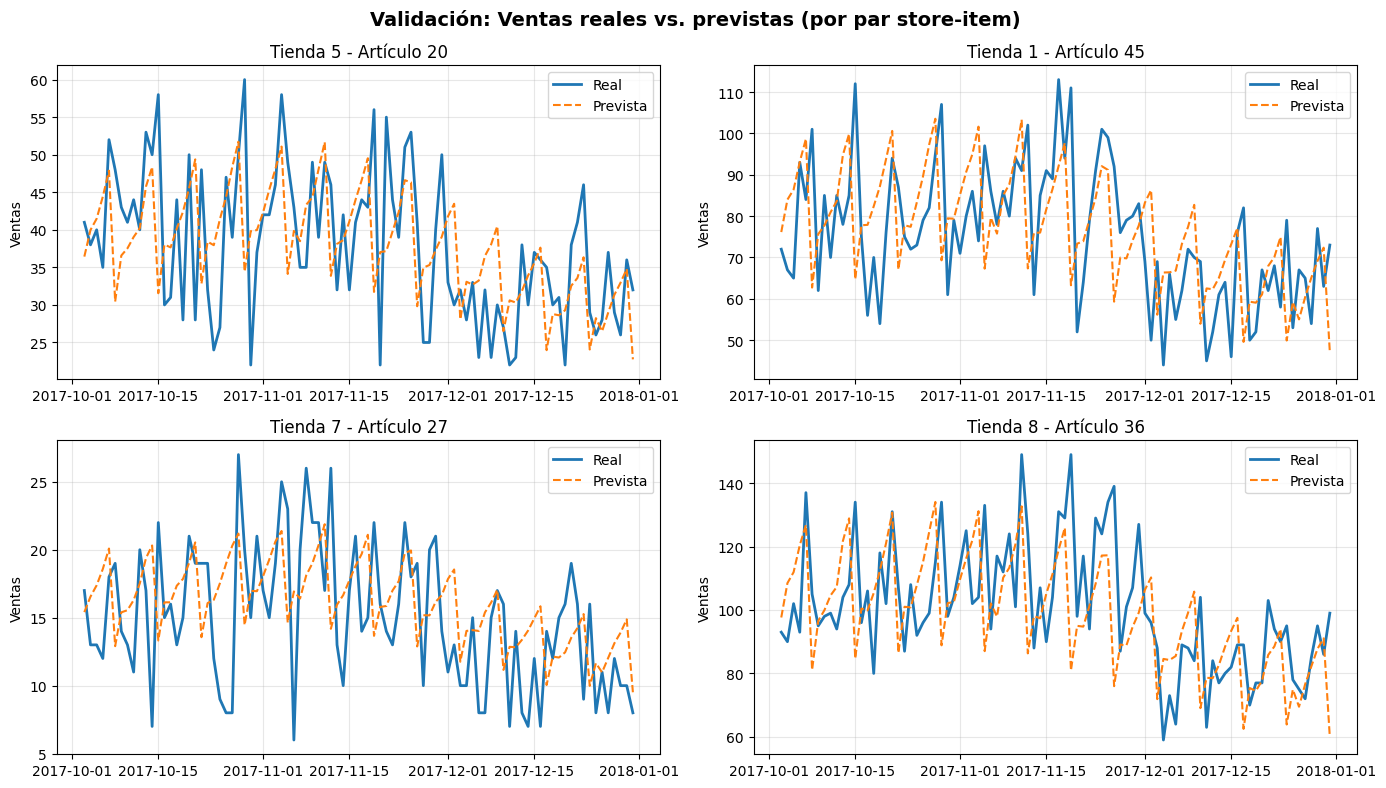

In [13]:
from datetime import timedelta

model_to_use = best_model if "best_model" in globals() else model
val_start = split_info["val_start"]
max_date = split_info["max_date"]


def plot_validation_pairs(
    train_df: pd.DataFrame,
    model: keras.Model,
    window_size: int,
    horizon: int,
    n_pairs: int = 4,
    seed: int = 42,
):
    """Grafica reales vs. previstas durante validación para n pares store-item."""
    rng = np.random.default_rng(seed)

    # Asegurar tipos y preparar lista de pares con datos suficientes
    df = train_df.copy()
    if not np.issubdtype(df["date"].dtype, np.datetime64):
        df["date"] = pd.to_datetime(df["date"])

    # Pairs con cobertura suficiente antes y durante validación
    val_mask = (df["date"] >= val_start) & (df["date"] <= max_date)
    pairs_all = df.loc[val_mask, ["store", "item"]].drop_duplicates().to_numpy()

    if len(pairs_all) == 0:
        print("No se encontraron pares con datos de validación.")
        return

    chosen_idx = rng.choice(
        len(pairs_all), size=min(n_pairs, len(pairs_all)), replace=False
    )
    chosen_pairs = pairs_all[chosen_idx]

    ncols = 2
    nrows = int(np.ceil(len(chosen_pairs) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows), sharex=False)
    axes = np.array(axes).reshape(-1)

    for ax, (s, it) in zip(axes, chosen_pairs):
        g = df[(df["store"] == s) & (df["item"] == it)].sort_values("date")

        # Historia para ventana y reales de validación
        g_hist = g[g["date"] < val_start]
        g_val = g[(g["date"] >= val_start) & (g["date"] <= max_date)].copy()

        if len(g_hist) < window_size or len(g_val) == 0:
            ax.axis("off")
            ax.set_title(f"store {int(s)} - item {int(it)} (sin datos suficientes)")
            continue

        feat_mat = (
            g_hist[
                [
                    "sales_log1p",
                    "sin_dow",
                    "cos_dow",
                    "sin_month",
                    "cos_month",
                    "is_weekend",
                ]
            ]
            .tail(window_size)
            .to_numpy(dtype=np.float32)
        )
        max_store = int(df["store"].max())
        max_item = int(df["item"].max())
        store_norm = np.full((window_size, 1), s / max_store, dtype=np.float32)
        item_norm = np.full((window_size, 1), it / max_item, dtype=np.float32)
        x_in = np.concatenate([feat_mat, store_norm, item_norm], axis=1)[
            np.newaxis, ...
        ]

        y_hat_log = model.predict(x_in, verbose=0)[0]
        y_hat = np.clip(np.expm1(y_hat_log), 0.0, None)
        y_hat = y_hat[: len(g_val)]

        # Series reales y previstas
        dates_val = g_val["date"].values
        y_true = g_val["sales"].values.astype(float)

        ax.plot(dates_val, y_true, label="Real", linewidth=2)
        ax.plot(dates_val, y_hat, label="Prevista", linestyle="--")
        ax.set_title(f"Tienda {int(s)} - Artículo {int(it)}")
        ax.set_ylabel("Ventas")
        ax.grid(alpha=0.3)
        ax.legend()

    # Ocultar ejes sobrantes
    for j in range(len(chosen_pairs), len(axes)):
        axes[j].axis("off")

    fig.suptitle(
        "Validación: Ventas reales vs. previstas (por par store-item)",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()


plot_validation_pairs(
    train_feat, model_to_use, window_size, horizon, n_pairs=4, seed=42
)

# 10 Interpretabilidad del modelo (SHAP)

Para interpretar qué características y puntos de la historia influyen más en los pronósticos, usamos SHAP con el GradientExplainer (Expected Gradients), recomendado para modelos de deep learning en Keras/TF y que combina ideas de Integrated Gradients y SHAP. Calculamos valores SHAP sobre una muestra de validación y:

- agregamos |SHAP| a lo largo del tiempo para obtener importancia por feature, y
- mostramos un mapa de calor de contribuciones por timestep y feature para un ejemplo concreto.


c:\Users\sergi\OneDrive - mazariegos.io 1\Sergio Orellana\Lab8-DL\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\sergi\OneDrive - mazariegos.io 1\Sergio Orellana\Lab8-DL\venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(32, 120, 8))']
  warnings.warn(msg)
c:\Users\sergi\OneDrive - mazariegos.io 1\Sergio Orellana\Lab8-DL\venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 120, 8))']
  warnings.warn(msg)



Importancia (|SHAP| agregado en tiempo):

    feature  abs_SHAP_sum
sales_log1p     41.422845


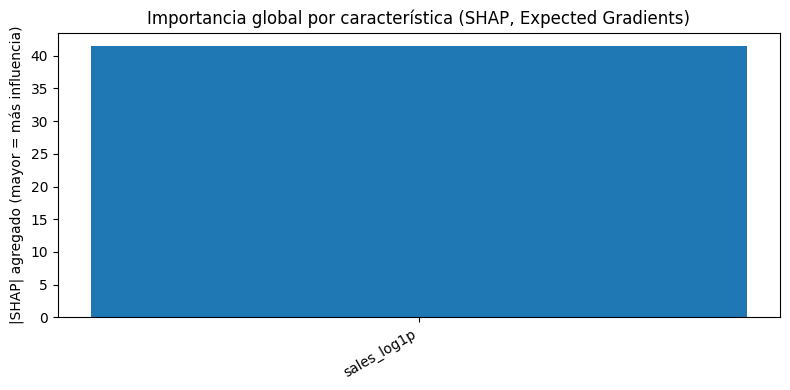

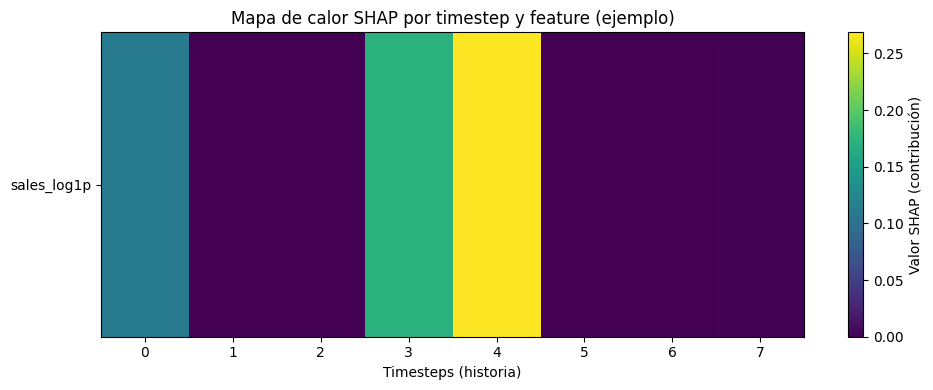

In [14]:
import sys, subprocess

try:
    import shap  # type: ignore
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "shap"])
    import shap  # type: ignore

model_to_explain = best_model if "best_model" in globals() else model

# Para explicar un escalar estable (suma de los próximos 'horizon' días),
# envolvemos el modelo con una capa que hace reduce_sum sobre la salida.
inp = model_to_explain.input
sum_out = keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1), name="sum_horizon")(
    model_to_explain.output
)
sum_model = keras.Model(inp, sum_out)

# Muestras de fondo y de explicación (limitadas por eficiencia)
bg_size = int(min(256, len(x_tr)))
ex_size = int(min(32, len(x_va)))
background = x_tr[:bg_size].astype(np.float32)
x_sample = x_va[:ex_size].astype(np.float32)

# Cálculo de SHAP con GradientExplainer (Expected Gradients)
explainer = shap.GradientExplainer(sum_model, background)
try:
    shap_values = explainer.shap_values(x_sample)  # posible API
    values = np.array(shap_values)
except Exception:
    exp = explainer(x_sample)  # API nueva devuelve Explanation
    values = exp.values

# Esperamos forma: (n_samples, timesteps, features)
if values.ndim == 4:
    # Algunas builds devuelven (outputs, n_samples, T, F) — tomamos el primer output
    values = values[0]

n_samples, T, F = values.shape
feature_names = [
    "sales_log1p",
    "sin_dow",
    "cos_dow",
    "sin_month",
    "cos_month",
    "is_weekend",
    "store_norm",
    "item_norm",
]
if F == 6:
    # Contingencia si no se incluyeron normalizadores en esta versión
    feature_names = [
        "sales_log1p",
        "sin_dow",
        "cos_dow",
        "sin_month",
        "cos_month",
        "is_weekend",
    ]

# Importancia por feature (agregando |SHAP| en tiempo y muestras)
abs_importance = np.abs(values).sum(axis=(0, 1))  # (features,)
imp_df = pd.DataFrame(
    {"feature": feature_names[: len(abs_importance)], "abs_SHAP_sum": abs_importance}
)
imp_df = imp_df.sort_values("abs_SHAP_sum", ascending=False).reset_index(drop=True)
print("\nImportancia (|SHAP| agregado en tiempo):\n")
print(imp_df.to_string(index=False))

plt.figure(figsize=(8, 4))
plt.bar(imp_df["feature"], imp_df["abs_SHAP_sum"])
plt.ylabel("|SHAP| agregado (mayor = más influencia)")
plt.title("Importancia global por característica (SHAP, Expected Gradients)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# Mapa de calor temporal para un ejemplo
ix = 0
example_shap = values[ix]  # (T, F)

# Reordenamos columnas según importancia para una visualización más clara
top_order = [
    feature_names.index(f) for f in imp_df["feature"].tolist() if f in feature_names
][: min(6, len(feature_names))]
example_shap_top = example_shap[:, top_order]
top_feature_labels = [feature_names[j] for j in top_order]

plt.figure(figsize=(10, 4))
plt.imshow(example_shap_top.T, aspect="auto", origin="lower")
plt.colorbar(label="Valor SHAP (contribución)")
plt.yticks(range(len(top_feature_labels)), top_feature_labels)
plt.xlabel("Timesteps (historia)")
plt.title("Mapa de calor SHAP por timestep y feature (ejemplo)")
plt.tight_layout()
plt.show()